# Amazon Bedrock boto3 Setup

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

For more details refer to the [`Bedrock` Workshop](https://github.com/aws-samples/amazon-bedrock-workshop)

---

## Prerequisites

Run the cells in this section to install the packages needed by the notebooks in this workshop. ⚠️ You will see pip dependency errors, you can safely ignore these errors. ⚠️

IGNORE ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [1]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"
%pip install "unstructured[csv]" "pillow>=9.5,<10" langchain==0.0.309 python-weather pypdf==3.8.1 faiss-cpu==1.7.4 --force-reinstall --quiet

  Using cached boto3-1.34.80-py3-none-any.whl.metadata (6.6 kB)
  Using cached awscli-1.32.80-py3-none-any.whl.metadata (11 kB)
  Using cached botocore-1.34.80-py3-none-any.whl.metadata (5.7 kB)
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.1-py3-none-any.whl.metadata (1.7 kB)
  Using cached docutils-0.16-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached colorama-0.4.4-py2.py3-none-any.whl.metadata (14 kB)
  Using cached rsa-4.7.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached urllib3-2.2.1-py3-none-any.whl.metadata (6.4 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached pyasn1-0.6.0-py2.py3-none-any.whl.metadata (8.3 kB)
Using cached boto3-1.34.80-py3-none-any.whl (139 kB)
Using cached awscli-1.32.80-py3-none-any

In [2]:
# Restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## Bedrock clients
This notebook demonstrates invoking Bedrock models directly using the AWS SDK

Here are links for some packages you might not be familiar with:

- [FAISS](https://github.com/facebookresearch/faiss), to store vector embeddings
- [sqlalchemy](https://www.sqlalchemy.org/), SQLAlchemy is the Python SQL toolkit 
- [PyPDF](https://pypi.org/project/pypdf/), for handling PDF files
- [IPyWidgets](https://ipywidgets.readthedocs.io/en/stable/), for interactive UI widgets in the notebook
- [NeMo-Guardrails](https://github.com/NVIDIA/NeMo-Guardrails) an open-source toolkit for easily adding programmable guardrails to LLM-based conversational systems


---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [3]:
import json
import os
import sys
import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
# os.environ["AWS_PROFILE"] = ""
# os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

model_parameter = {"temperature": 0.0, "top_p": .5, "max_tokens_to_sample": 2000}

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Invoke Model

we will demonstrate the use of invoking the models and also highlight the default behaviour of LLM. They will return answer and data based on the training data. For our use case of AiStylist we need more curated responses. That means we will need to adopt a different architecture to get the model to execute our use case. Those techniques will be demonstrated in the next workbook

*Note: I changed the model from anthropic.claude-v2 to amazon.titan-text-express-v1 and updated the prompt.*

In [4]:
prompt = """
I am a female consultant in my 30s traveling to New York next week.
What kind of outfit should I wear on my first day in the office?
"""

body = json.dumps({"inputText": prompt, "textGenerationConfig" : {"maxTokenCount": 600}})
modelId = "amazon.titan-text-express-v1"
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

styles_response = response_body['results'][0]['outputText']
print(styles_response)


If you are a female consultant in your 30s traveling to New York for work, here are some outfit ideas to consider for your first day in the office:

1. Classic Business Suit: A tailored black or navy business suit is a classic and professional choice. Pair it with a crisp white or light-colored blouse, a conservative tie, and polished black heels.
2. Blouse and Trousers: A blouse paired with tailored trousers or a skirt is a versatile and feminine option. Choose a blouse in a neutral color like white, black, or gray, and pair it with tailored trousers or a pencil skirt in a complementary color.
3. Skirt Suit: A skirt suit is a great choice for a more formal look. Opt for a tailored skirt suit in a neutral color like black, gray, or navy, and pair it with a blouse or button-down shirt in a complementary color.
4. Pencil Skirt and Blouse: A pencil skirt paired with a blouse is a classic and elegant choice. Choose a pencil skirt in a neutral color like black, gray, or navy, and pair it w

## Generate the default images using stability.stable-diffusion-xl

Preparing received response to generate images for each style look

In [9]:
# Prepare input for fetching images for each of style
styles = [s.strip() for s in (list(filter(None, styles_response.splitlines()))[1:-1])]
print(*styles, sep='\n')

1. Classic Business Suit: A tailored black or navy business suit is a classic and professional choice. Pair it with a crisp white or light-colored blouse, a conservative tie, and polished black heels.
2. Blouse and Trousers: A blouse paired with tailored trousers or a skirt is a versatile and feminine option. Choose a blouse in a neutral color like white, black, or gray, and pair it with tailored trousers or a pencil skirt in a complementary color.
3. Skirt Suit: A skirt suit is a great choice for a more formal look. Opt for a tailored skirt suit in a neutral color like black, gray, or navy, and pair it with a blouse or button-down shirt in a complementary color.
4. Pencil Skirt and Blouse: A pencil skirt paired with a blouse is a classic and elegant choice. Choose a pencil skirt in a neutral color like black, gray, or navy, and pair it with a blouse in a contrasting color or pattern.
5. Midi Dress: A midi dress is a stylish and comfortable option for a first day in the office. Choose 

1. Classic Business Suit: A tailored black or navy business suit is a classic and professional choice. Pair it with a crisp white or light-colored blouse, a conservative tie, and polished black heels.


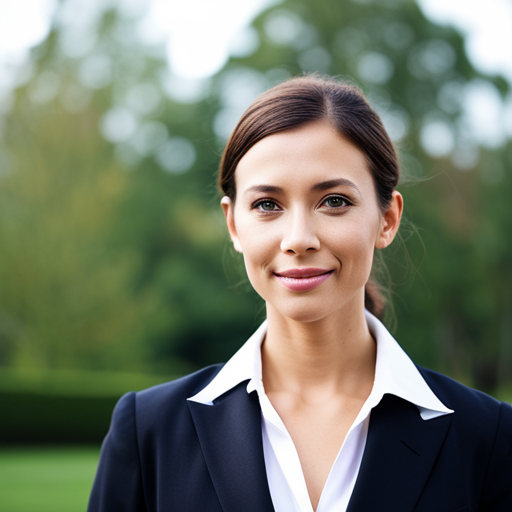

2. Blouse and Trousers: A blouse paired with tailored trousers or a skirt is a versatile and feminine option. Choose a blouse in a neutral color like white, black, or gray, and pair it with tailored trousers or a pencil skirt in a complementary color.


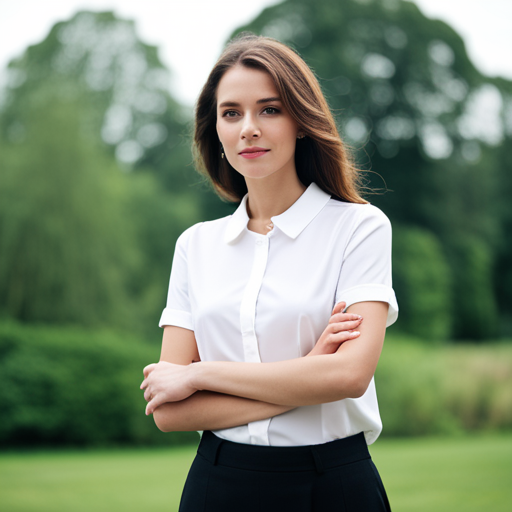

3. Skirt Suit: A skirt suit is a great choice for a more formal look. Opt for a tailored skirt suit in a neutral color like black, gray, or navy, and pair it with a blouse or button-down shirt in a complementary color.


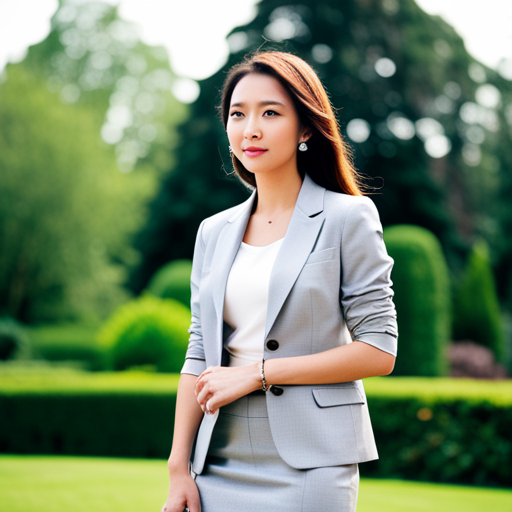

4. Pencil Skirt and Blouse: A pencil skirt paired with a blouse is a classic and elegant choice. Choose a pencil skirt in a neutral color like black, gray, or navy, and pair it with a blouse in a contrasting color or pattern.


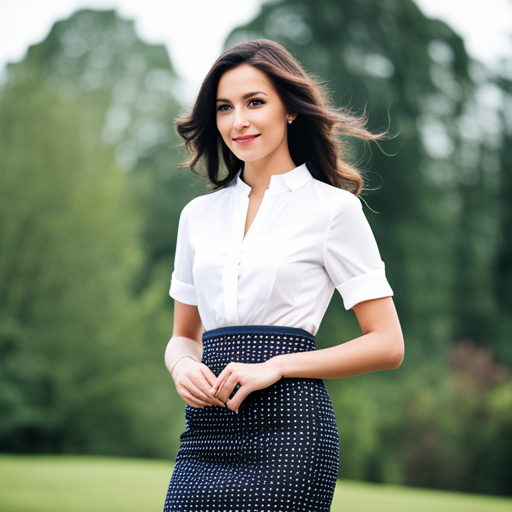

5. Midi Dress: A midi dress is a stylish and comfortable option for a first day in the office. Choose a dress in a neutral color like black, white, or navy, and pair it with a blazer or cardigan for a more professional look.


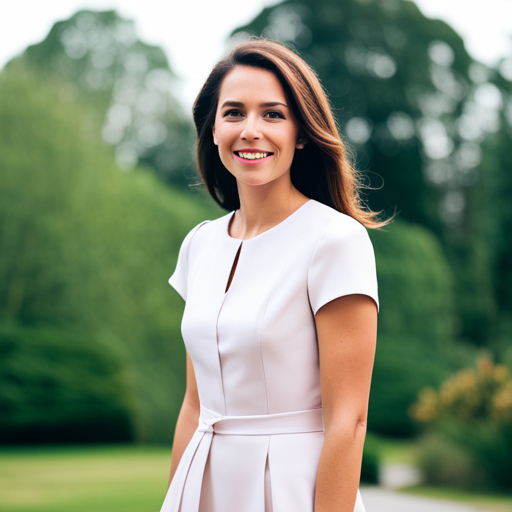

6. Blouse and Trousers with Statement Piece: If you want to add a statement piece to your outfit, consider pairing a blouse with tailored trousers or a skirt with a bold scarf or statement necklace.


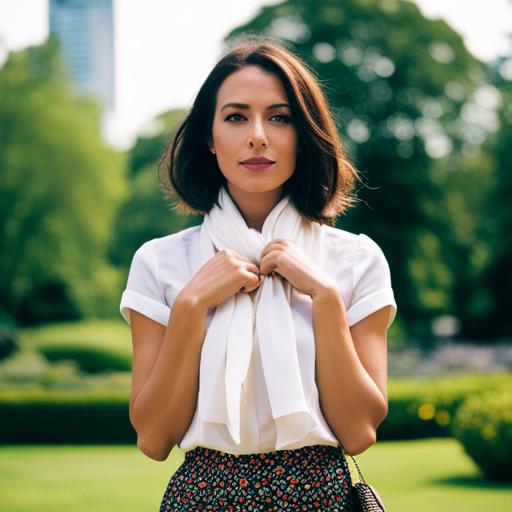

7. Pencil Skirt and Sweater: A pencil skirt paired with a cozy sweater is a great choice for a more casual but professional look. Choose a pencil skirt in a neutral color like black, gray, or navy, and pair it with a sweater in a complementary color or pattern.


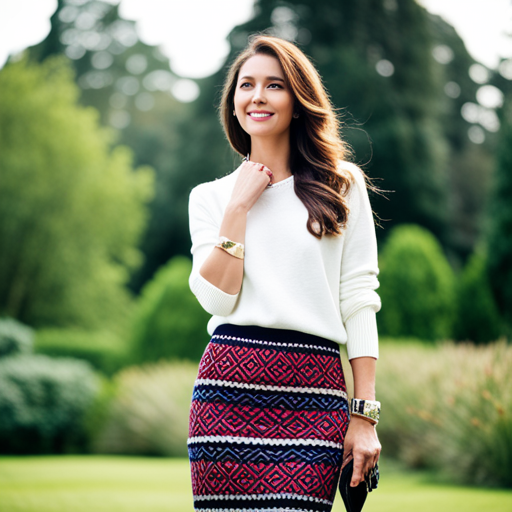

8. Skirt and Blouse with Pattern: If you love to incorporate patterns into your wardrobe, consider pairing a skirt with a blouse with a bold pattern. Choose a skirt in a neutral color like black, gray, or navy, and pair it with a blouse in a contrasting pattern like stripes, plaid, or floral.


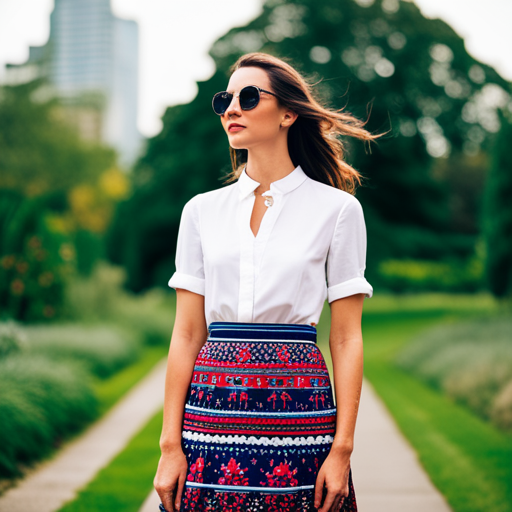

9. Dress and Jacket: A dress paired with a blazer or jacket is a classic and professional look. Choose a dress in a neutral color like black, white, or navy, and pair it with a blazer or jacket in a contrasting color or pattern.


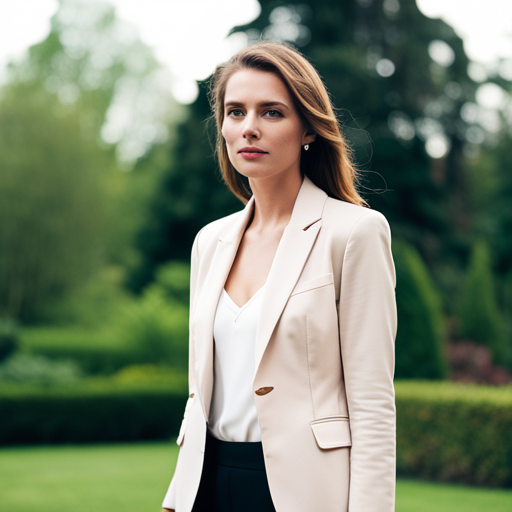

10. Leather Jacket and Trousers: A leather jacket paired with tailored trousers is a stylish and edgy option. Choose a leather jacket in a neutral color like black or gray, and pair it with tailored trousers in a complementary color.


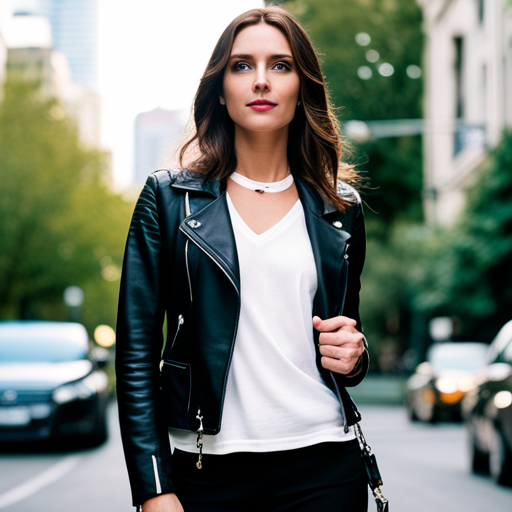

In [13]:
from PIL import Image
from IPython import display
from base64 import b64decode
import base64
import io
import json
import os
import sys

# Fetching images for each style
os.makedirs("data", exist_ok=True)
images = []
for style in styles:
    print(style)
    if len(style.split(":")) > 1:
        request = json.dumps({
            "text_prompts": (
                [{"text": "woman wearing " + style.split(":")[1], "weight": 1.0}]
            ),
            "cfg_scale": 5,
            "seed": 1005,
            "steps": 70,
            "style_preset": "photographic",
        })
        modelId = "stability.stable-diffusion-xl"
        
        response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
        response_body = json.loads(response.get("body").read())
        
        base_64_img_str = response_body["artifacts"][0].get("base64")
        display.display(display.Image(b64decode(base_64_img_str), width=200))